In [3]:
import pandas as pd
from sacrebleu.metrics import BLEU
from typing import Generator, Tuple

In [59]:
SOURCES = "../../data/en-fr/raw/test.fr"
REFERENCES = "../../data/en-fr/raw/test.en"
RAIN_SOURCES_TOKENIZED = "../../data/en-fr/preprocessed/train.fr"
TEST_SOURCES_TOKENIZED = "../../data/en-fr/preprocessed/test.fr"

#HYPOTHESES = "baseline/translations.p.txt"

HYPOTHESES = "spm_vanilla/translations/postprocessed_spm_vanilla_fully_trained.txt"
#TRAIN_SOURCES_TOKENIZED = "spm_vanilla/data/preprocessed/train.fr"
#TEST_SOURCES_TOKENIZED = "spm_vanilla/data/preprocessed/test.fr"

In [60]:
def shr_generator() -> Generator[Tuple[str, str, str, str], None, None]:
    with open(SOURCES, "r") as sources, open(HYPOTHESES, "r") as hypotheses, open(REFERENCES, "r") as references, open(TEST_SOURCES_TOKENIZED) as source_tokenized:
        for s, h, r, st in zip(sources, hypotheses, references, source_tokenized):
            yield s.strip(), h.strip(), r.strip(), st.strip()

shr = [x for x in shr_generator()]
df = pd.DataFrame(shr, columns=["source", "hypothesis", "reference", "source_tokenized"])

In [61]:
bleu = BLEU(effective_order=True)

def add_bleu(row):
    b_score = bleu.sentence_score(row["hypothesis"], [row["reference"]])
    return b_score.score

df["bleu"] = df.apply(lambda row: add_bleu(row), axis=1)
df.head()
    

,source,hypothesis,reference,source_tokenized,bleu
0,Linda va être ici.,We'll be here to be here.,Linda will be here.,Linda va être ici .,24.446151
1,Je crains que vous ne soyez descendu au mauvai...,I'm afraid that you've never got to be punctual.,I'm afraid you got off at the wrong place.,je crains que vous ne soyez descendu au mauvai...,9.980099
2,Je ferme la porte ?,I'm lucky to leave the door?,Shall I close the door?,je ferme la porte ?,24.446151
3,Il abuse de son autorité.,He has no beach to his figation.,He abuses his authority.,il abuse de son autorité .,7.267884
4,Il est plus grand que tous les autres garçons.,He is taller than all the others that all the ...,He is taller than any other boy.,il est plus grand que tous les autres garçons .,22.416934


In [63]:
df["source_len"] = df.source.apply(lambda x: len(str(x)))

<AxesSubplot:xlabel='source_len', ylabel='bleu'>

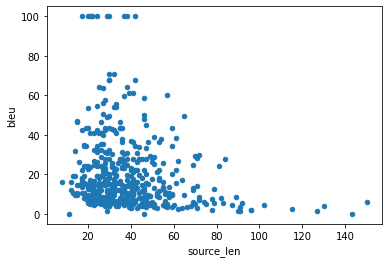

In [69]:
df.plot.scatter("source_len", "bleu")

<AxesSubplot:xlabel='source_len'>

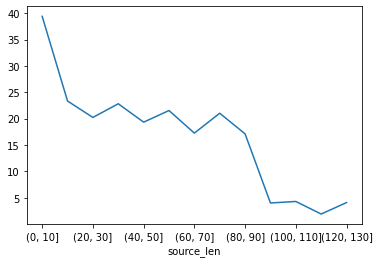

In [21]:
#from matplotlib import pyplot as plt

bins = list(range(0,150,10))
grouped = df.groupby(pd.cut(df["source_len"], bins=bins)).mean()
grouped["bleu"].plot()

In [19]:
df[df["bleu"] > 80]

,source,hypothesis,reference,source_tokenized,bleu
24,Vous êtes chanceuse d'avoir un emploi.,You're lucky to have a job.,You're lucky to have a job.,vous êtes chanceuse d&apos; avoir un emploi .,100.000000
86,Je sais que tu veux rentrer chez toi.,I know you want to go home.,I know you want to go home.,je sais que tu veux rentrer chez toi .,100.000000
89,Je pense que Tom est réveillé.,I think Tom is awake.,I think Tom is awake.,je pense que Tom est réveillé .,100.000000
211,Je sais que vous êtes amoureux de moi !,I know you're in love with me!,I know you're in love with me.,je sais que vous êtes amoureux de moi !,84.089642
214,Comment suis-je supposé manger ?,How am I supposed to eat?,How am I supposed to eat?,comment suis @-@ je supposé manger ?,100.000000
298,As-tu des questions ?,Do you have any questions?,Do you have any questions?,as @-@ tu des questions ?,100.000000
307,Quelle est l'idée ?,What's the idea?,What's the idea?,quelle est l&apos; idée ?,100.000000
391,Je n'ai aucune idée de ce que nous sommes supp...,I have no idea what we're supposed to do.,I have no idea what we're supposed to do.,je n&apos; ai aucune idée de ce que nous somme...,100.000000
470,Qu'êtes-vous censé faire ?,What are you supposed to do?,What are you supposed to do?,qu&apos; êtes @-@ vous censé faire ?,100.000000
476,Tom pourrait faire cela.,Tom could do that.,Tom could do that.,Tom pourrait faire cela .,100.000000


In [44]:
from collections import Counter

word_counts = Counter()

with open(TRAIN_SOURCE) as f:
    for line in f:
        word_counts += Counter(line.split(" "))

def known_ratio(tokenized_sentence: str) -> float:
    known = 0
    total = 0
    for token in tokenized_sentence.split(" "):
        if token in word_counts:
            known += 1
        total += 1
    return known / total

def rare_ratio(tokenized_sentence: str, threshold: float = 0.001) -> float:
    rare = 0
    total = 0
    train_size = sum(word_counts.values())
    for token in tokenized_sentence.split(" "):
        if word_counts[token] / train_size < threshold:
            rare += 1
        total += 1
    return rare / total

dfknown_ratio = df.source_tokenized.apply(known_ratio)
df.rare_ratio = df.source_tokenized.apply(rare_ratio)

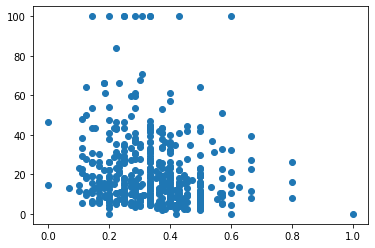

In [46]:
import matplotlib.pyplot as plt

plt.scatter(df.rare_ratio, df.bleu)

0.25